# 载入作业所需函数库

In [136]:
#coding=utf-8  
import sys
import math as mh
import pprint as pp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt                       #导入快速绘图包函数
import pylab as pl
import csv
import importlib
from scipy import linalg
from __future__ import division
from gensim import corpora, models
import os
import re
import jieba
importlib.reload(sys)
sys.path.append('D:\bigdatahw\python\hw3')            #增加搜索路径
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] #指定默认字体  
plt.rcParams['axes.unicode_minus'] = False            # 解决保存图像是负号'-'显示为方块的问题

# 一、Part1 Of Lab1
$~~~~~~~$本次作业的part1部分采用的文本数据是在网易云音乐网站上爬取的歌词文本数据，歌词数据为文件夹中的696个txt格式的歌词文本文件，其中每个文本文件都是一首歌曲的歌词，并且歌词为中文。本节所做的任务是基本的歌词文本的批量读入，并将每一个歌词的文本进行清理，去除"\n","\3000"等换行符和制表符，并通过停词表去掉歌词文本中的标点符号，空格以及各种停词，将每首歌曲的文本转化为各种的汉语词汇，并将这些词汇存储在字典中，并输出为csv格式。

### 1.1 Read a text file
+ 定义文件夹打开函数和txt文件读取函数

In [97]:
path_doc_root = 'C:/Users/Bokkin Wang/data/'  # 根目录 即存放按类分类好的问本纪
class loadFolders(object):   # 迭代器
    def __init__(self, par_path):
        self.par_path = par_path

    def __iter__(self):
        for file in os.listdir(self.par_path):
            file_abspath = os.path.join(self.par_path, file)
            if os.path.isdir(file_abspath):  
                yield file_abspath

class loadFiles(object):
    def __init__(self, par_path):
        self.par_path = par_path

    def __iter__(self):
        folders = loadFolders(self.par_path)
        for folder in folders:              
            catg = folder.split(os.sep)[-1]
            for file in os.listdir(folder):     
                file_path = os.path.join(folder, file)
                if os.path.isfile(file_path):
                    this_file = open(file_path, 'rb')
                    content = this_file.read().decode('utf8')
                    yield catg, content
                    this_file.close()

### 1.2 Do the necessary cleaning
+ 停词清理函数
+ 分词处理函数
+ 制表符，换行符，空格符处理函数
+ 完全数字清理函数

In [ ]:
def convert_doc_to_wordlist(str_doc, cut_all):
    sent_list = str_doc.split('\n')
    sent_list = map(rm_char, sent_list)                       # 去掉一些字符，例如\u3000
    word_2dlist = [rm_tokens(jieba.cut(part, cut_all=cut_all))
                   for part in sent_list]                     # 分词
    word_list = sum(word_2dlist, [])
    return word_list

def rm_tokens(words):                                        # 去掉一些停用词和完全包含数字的字符串
    words_list = list(words)
    stop_words = get_stop_words()
    for i in range(words_list.__len__())[::-1]:
        if words_list[i] in stop_words:                      # 去除停用词
            words_list.pop(i)
        elif words_list[i].isdigit():
            words_list.pop(i)
    return words_list

def get_stop_words(path='C:/Users/Bokkin Wang/data/stopWord.txt'):
    file = open(path, 'rb').read().decode('utf8').split('\n')
    return set(file)                                         #查分停用词函数

def rm_char(text):
    text = re.sub('\u3000', '', text)                        #全角的空白符
    return text

### 1.3 Convert to other format
将每首歌歌词转化为字典的键值

In [113]:
files = loadFiles(path_doc_root)
dictionary={} 
for i, msg in enumerate(files):
    file = msg[1]
    file = convert_doc_to_wordlist(file, cut_all=False)
    dictionary[str(i)]= file

### 1.4 Export to csv format
将每首歌词的分词的汉语词汇传入到csv中，并保存

In [119]:
#写入csv
csvfile = open('C:/Users/Bokkin Wang/data/word.csv','w',encoding='utf-8') 
writer = csv.writer(csvfile)
for i in list(dictionary.keys()):
    row=dictionary.get(i)
    writer.writerow(row)
csvfile.close()

# 二、Part2 Of Lab1
$~~~~~~~$本部分实验选取了UCI机器学习数据集库中选取了经典的贷款数据Creditcard数据集，并利用该数据进行描述性分析以及相应的线性计算。该Creditcard数据集是对65535个贷款人样本的贷款人口学描述信息以及用户分类的记录。

$~~~~~~~$贷款数据包含有65535只鲍鱼的贷款信息，其中将这65535个贷款人按照贷款资质分为12类用户。除过贷款人的人口学特征以外还包含着描述贷款人贷款时间的描述信息以及每个用户的违约严重程度。该数据集的属性信息以及变量描述如表1-1所示，表中给定的是变量名称，变量类型，度量单位和简要描述。从原始数据中删除了缺失值的例子。


$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$<font face="黑体" size=4>表1-1 属性变量说明表</font>

变量 | 取值范围 | 详细说明 | 备注
:-:|:-:|:-:|:-:
性别 |女，男 | 分类变量，反映顾客性别状况 | 通过观察性别变量反映性别影响顾客分类和信誉
年龄 | 0~130岁 | 数值型变量，反映顾客年龄状况 | 数据中出现并不合理的数据，这会在预处理中进行数据的处理
受教育程度 |未上学儿童，小学，初中，高中或中专，大学及以上| 分类变量，反映顾客的教育程度 | 受教育程度可能会影响顾客收入和信誉，进而影响顾客分类
职业 |在校学生，家务，待业，其他等 |分类变量，反映顾客职业状况 | 不同的客户分类中的从事各种工作的比例也可能不同进而影响各类顾客评分。
违约发生时间 | 20160101~20171213 | 日期型变量 | 可进一步转化为违约时长，用于判断违约程度
违约严重程度 | 轻度、中度、重度 |分类变量，共有三个违约分类 | 代表着顾客的单词的违约程度
顾客代码 | 顾客1,2，…,12 | 分类变量  | 标记顾客所属的顾客群体

### 2.1 Read a csv flie
读取csv文档并保存为数据字典格式，每一个键对应的都是一个变量，而键值则为变量值。

In [32]:
data = {'Gender':[], 'age':[], 'education' : [],'occupation' : [],'time' : [],'degree' : [],'code' : []}
with open('CreditCard.csv', 'r',encoding='utf-8-sig') as f:
    reader = csv.DictReader(f, delimiter=',')
    for row in reader:
        data['Gender'].append(row["Gender"])
        data['age'].append(row["age"])
        data['education'].append(row["education"])
        data['occupation'].append(row["occupation"])
        data['time'].append(row["time"])
        data['degree'].append(row["degree"])
        data['code'].append(row["code"])

### 2.2 Do the description

#### 2.2.1 利用列表，字典，元组进行描述性统计分析
+ 进行数据清理工作删除具有缺失的记录

In [34]:
type(data.get('age'))     #字典的键值为list列表
for item in list(data.keys()):
    if u'' in data.get(item):
        print ('There are any nulls in %s'%item)

There are any nulls in age
There are any nulls in education
There are any nulls in occupation
There are any nulls in degree


In [35]:
#重新读入数据将含有空值的记录删除
data = {'Gender':[], 'age':[], 'education' : [],'occupation' : [],'time' : [],'degree' : [],'code' : []}
with open('CreditCard.csv', 'r',encoding='utf-8-sig') as f:
    reader = csv.DictReader(f, delimiter=',')
    for row in reader:
        if (row["age"]=='')|(row["education"]=='')|(row["occupation"]=='')|(row["degree"]==''):
            continue
        else:
            data['Gender'].append(row["Gender"])
            data['age'].append(row["age"])
            data['education'].append(row["education"])
            data['occupation'].append(row["occupation"])
            data['time'].append(row["time"])
            data['degree'].append(row["degree"])
            data['code'].append(row["code"])

In [36]:
type(data.get('age'))                             #字典的键值为list列表
for item in list(data.keys()):
    if u'' in data.get(item):
        print ('There are any nulls in %s'%item)  #已经没有了空值
len(data.get('age'))                              #删除了331条有空值的记录

65204

In [37]:
pd.Series(data)

Gender        [男, 男, 男, 女, 女, 男, 男, 女, 男, 男, 男, 女, 男, 女, 男, ...
age           [69, 60, 28, 27, 19, 7, 57, 21, 35, 26, 45, 52...
code          [顾客1, 顾客1, 顾客1, 顾客1, 顾客1, 顾客1, 顾客1, 顾客1, 顾客1, ...
degree        [轻度, 轻度, 轻度, 轻度, 轻度, 轻度, 轻度, 轻度, 轻度, 轻度, 轻度, 轻...
education     [高中或中专, 高中或中专, 大专, 大专, 高中或中专, 小学, 小学, 大学及以上, 高...
occupation    [离退休人员, 商业、服务业人员, 专业技术人员, 办事人员和有关人员, 办事人员和有关人员...
time          [2016-12-29 18, 2016-12-12 09, 2016-12-16 23, ...
dtype: object

+ 统计违约总人数
+ 统计总的违约年龄和年龄的最值状况
+ 统计各类型的客户群体的人数
+ 统计各类型的客户群体的平均年龄
+ 统计各职业的用户群体的人数以及所占比例

In [38]:
#信用卡用户的分类汇总
sum_age=0
count = 0              #统计各个分类的总人数
avg_age = 0            #计算各个顾客群体群体的平均年龄
dict_count = {}        #用于储存各个顾客群体的人数统计的字典
dict_sum_age = {}      #统计各个顾客群体群体的总年龄
code = data.get('code')
for i in list(range(len(code)-1)):
    count = count + 1
    sum_age = sum_age + float(data.get('age')[i])
    dict_count[data.get('code')[i]]=dict_count.setdefault(data.get('code')[i],0)+1
    dict_sum_age[data.get('code')[i]]=dict_sum_age.setdefault(data.get('code')[i],0)+float(data.get('age')[i]) #通过键给到键值
avg_age=float(sum_age)/(count)    #总平均年龄
print ('违约记录总人数:%d'%count)
print ('违约记录平均年龄:%f'%avg_age)

违约记录总人数:65203
违约记录平均年龄:33.883548


In [39]:
dict_avg_age={} 
for key in dict_count:
     dict_avg_age[key]=round(dict_sum_age[key]/dict_count[key],2)
print (dict_count)           #统计显示贷款的各个职业的人数
print (dict_avg_age)         #统计显示贷款的各个职业的平均年龄

{'顾客1': 8060, '顾客6': 254, '顾客7': 236, '顾客8': 2700, '顾客9': 333, '顾客10': 2650, '顾客11': 196, '顾客12': 7386, '顾客2': 34791, '顾客3': 5969, '顾客4': 1776, '顾客5': 852}
{'顾客1': 36.79, '顾客6': 6.89, '顾客7': 30.22, '顾客8': 24.83, '顾客9': 32.9, '顾客10': 35.7, '顾客11': 24.45, '顾客12': 35.86, '顾客2': 32.99, '顾客3': 39.77, '顾客4': 32.89, '顾客5': 21.3}


In [40]:
dict_occu_count={}    #用于储存各个客户分类的人数统计的字典
for i in list(range(len(code)-1)):
    dict_occu_count[data.get('occupation')[i]]=dict_occu_count.setdefault(data.get('occupation')[i],0)+1
dict_occu_perc={}     #用于储存百分占比
for key in dict_occu_count:
    dict_occu_perc[key]=round((float(dict_occu_count[key])/len(code))*100,3)
perc_list = list(dict_occu_perc.values())
print (dict_occu_perc)
print (dict_occu_count)

{'离退休人员': 5.94, '商业、服务业人员': 19.157, '专业技术人员': 12.117, '办事人员和有关人员': 8.914, '在校学生': 11.2, '农牧渔水利业生产人员': 5.941, '生产运输设备操作人员及有关人员': 15.083, '学龄前儿童': 10.331, '其他/不清楚': 3.997, '家务': 5.923, '待业': 1.279, '军人': 0.117}
{'离退休人员': 3873, '商业、服务业人员': 12491, '专业技术人员': 7901, '办事人员和有关人员': 5812, '在校学生': 7303, '农牧渔水利业生产人员': 3874, '生产运输设备操作人员及有关人员': 9835, '学龄前儿童': 6736, '其他/不清楚': 2606, '家务': 3862, '待业': 834, '军人': 76}


In [41]:
age = data.get('age' )                         #将年龄信息赋值给age用以画出直方图
age = [float(x) for x in age]                  #利用列表解析式进行变量形式的转换
print ([x for x in age if x>100])              #寻找异常值
age = [float(x) for x in age if x<100]         #利用列表解析式进行变量形式的转换

print ('贷款人最大年龄:%f'%max(age))           #对年龄信息进行描述性分析
print ('贷款人最小年龄:%f'%min(age))

[283.0, 104.0, 106.0, 173.0, 102.0, 102.0, 104.0, 890.0]
贷款人最大年龄:99.000000
贷款人最小年龄:0.000000


#### 2.2.2 利用matplotlib包和seaborn包进行描述性统计分析
+ 年龄分布状况

C:\Users\Bokkin Wang\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


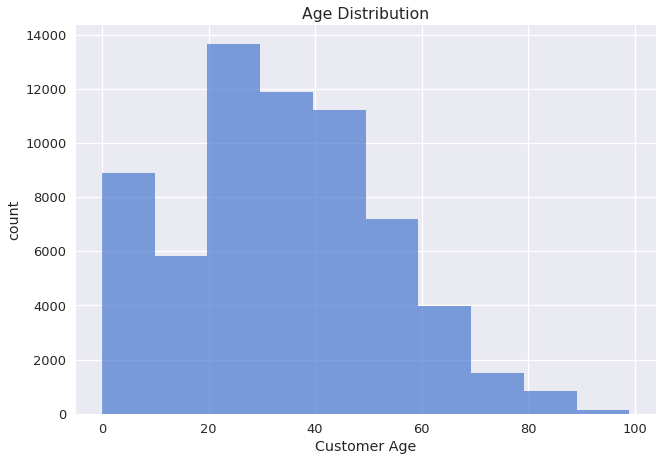

In [42]:
plt.title('Age Distribution') # give plot a title
plt.hist(age,alpha=0.7)              
plt.xlabel('Customer Age')
plt.ylabel('count')
plt.show()

+ 顾客年龄分布 
+ 顾客年龄密度曲线
+ 顾客年龄箱线图

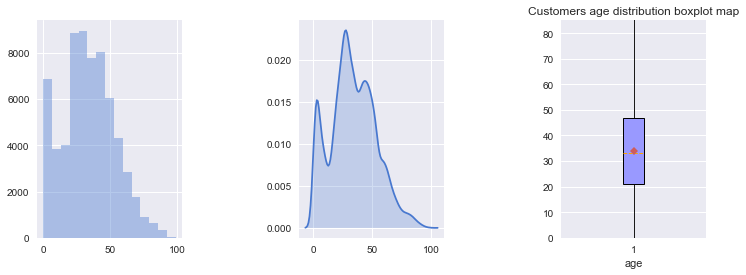

In [80]:
# coding: utf-8
age=pd.Series(age)
mydata=pd.read_csv('D:/bigdatahw/python/hw3/CreditCard.csv',header=0)
mydata.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True) #去除含有缺失值的记录
sns.set(style="darkgrid", palette="muted", color_codes=True)  #set( )设置主题，调色板更常用 
fig, axes = plt.subplots(1,3,figsize=(12, 4))                 #创建一个显得Figure并返回已创建的subplot的numpy数组
sns.distplot(age,ax = axes[0],bins=15,kde = False)            #做年龄分布直方图
plt.title('顾客年龄分布直方图') 
sns.kdeplot(age,ax = axes[1],shade=True)                      #做年龄分布密度曲线
plt.title('顾客年龄分布密度曲线') 
pl.xlabel('age')
# 绘图：整体乘客的年龄箱线图  
plt.boxplot(x = "age",
            data=mydata,# 指定绘图数据
            patch_artist=True, # 要求用自定义颜色填充盒形图，默认白色填充  
            showmeans=True, # 以点的形式显示均值  
            boxprops = {'color':'black','facecolor':'#9999ff'}, # 设置箱体属性，填充色和边框色  
            flierprops = {'marker':'o','markerfacecolor':'red','color':'black'}, # 设置异常值属性，点的形状、填充色和边框色  
            meanprops = {'marker':'D','markerfacecolor':'indianred'},
            medianprops = {'linestyle':'--','color':'orange'}) # 设置均值点的属性，点的形状、填充色  
# 设置y轴的范围  
plt.ylim(0,85)  
# 去除箱线图的上边框与右边框的刻度标签  
plt.tick_params(top='off', right='off')  
plt.title('Customers age distribution boxplot map') 
pl.xlabel('age')
plt.subplots_adjust(wspace=0.8)
plt.show()

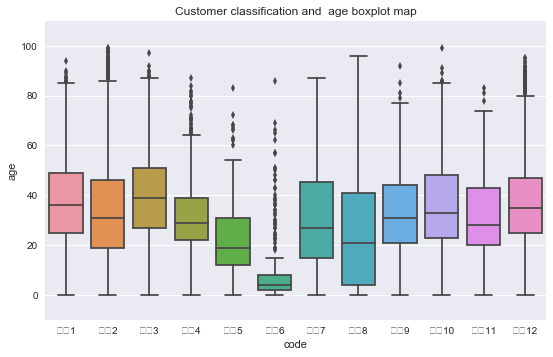

In [48]:
mydata['age']=age
sns.set(style="darkgrid", palette="muted", color_codes=True)  
#绘制箱线图年龄与客户分类关系
sns.boxplot(x = "code",y ="age",data=mydata, order=["顾客1", "顾客2","顾客3","顾客4","顾客5","顾客6","顾客7","顾客8","顾客9","顾客10","顾客11","顾客12"])  
pl.subplots_adjust(left=0.08, right=0.95, wspace=0.25, hspace=0.45)
plt.title('Customer classification and  age boxplot map') 
plt.ylim(-10.0, 110.0)
plt.show()  

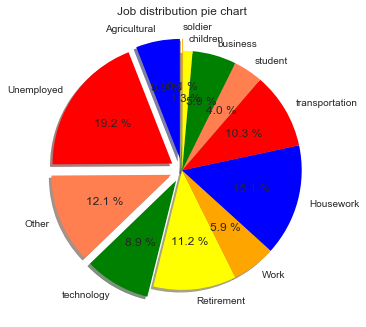

In [45]:
labels = ['Agricultural','Unemployed', 'Other','technology','Retirement','Work','Housework','transportation','student','business','children','soldier']
fracs =perc_list
explode = [0.1,0.1,0.1,0.1,0,0,0,0,0,0,0,0.1] # 0.1 凸出这部分，
plt.axes(aspect=1)  # set this , Figure is round, otherwise it is an ellipse
#autopct ，show percet
plt.pie(x=fracs, labels=labels, explode=explode,autopct='%3.1f %%',colors  = ["blue","red","coral","green","yellow","orange"],
        shadow=True, labeldistance=1.1, startangle = 90,pctdistance = 0.6)
plt.title('Job distribution pie chart')
'''
labeldistance，文本的位置离远点有多远，1.1指1.1倍半径的位置
autopct，圆里面的文本格式，%3.1f%%表示小数有三位，整数有一位的浮点数
shadow，饼是否有阴影
startangle，起始角度，0，表示从0开始逆时针转，为第一块。一般选择从90度开始比较好看
pctdistance，百分比的text离圆心的距离
patches, l_texts, p_texts，为了得到饼图的返回值，p_texts饼图内部文本的，l_texts饼图外label的文本
'''
 
plt.show()

In [58]:
for i in list(range(len(data.get('degree')))) :
    if data.get('degree')[i]=='重度':
        data.get('degree')[i]='severe'
    elif data.get('degree')[i]=='中度':
        data.get('degree')[i]='moderate'
    elif data.get('degree')[i]=='轻度':
        data.get('degree')[i]='light'
for i in list(range(len(data.get('Gender')))) :
    if data.get('Gender')[i]=='男':
        data.get('Gender')[i]='man'
    elif data.get('Gender')[i]=='女':
        data.get('Gender')[i]='woman'


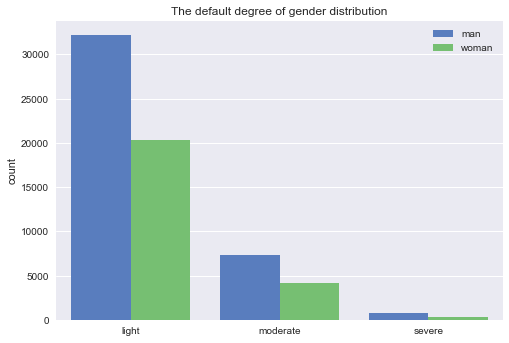

In [59]:
sns.countplot(x = data.get('degree'),hue = data.get('Gender'))
plt.title('The default degree of gender distribution') 
plt.show()

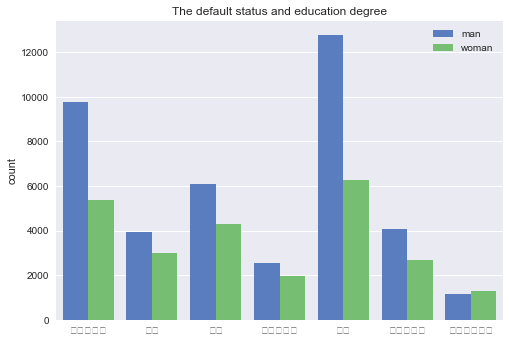

array(['初中', '大专', '大学及以上', '小学', '文盲、半文盲', '未上学儿童', '高中或中专'], dtype='<U6')

In [64]:
sns.countplot(x = data.get('education'),hue = data.get('Gender'))
plt.title('The default status and education degree') 
plt.show()

C:\Users\Bokkin Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Bokkin Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Bokkin Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C

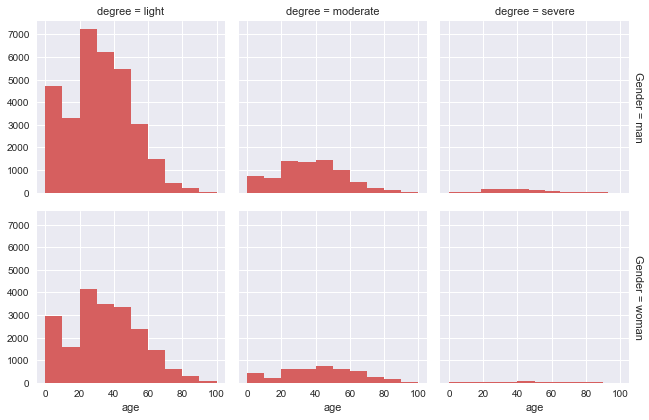

In [83]:
mydata["degree"][mydata["degree"]=='轻度']='light'
mydata["degree"][mydata["degree"]=='中度']='moderate'
mydata["degree"][mydata["degree"]=='重度']='severe'
mydata["Gender"][mydata["Gender"]=='男']='man'
mydata["Gender"][mydata["Gender"]=='女']='woman'
mydata["age"][mydata["age"]>100]=100
g = sns.FacetGrid(mydata, col= "degree", row="Gender",margin_titles=True)  
g = g.map(plt.hist, "age",  color="r")  
plt.show()  

### 2.3 Convert it to dataframe

In [84]:
pd.Series(data)                  #清楚地查看字典形式
data = pd.DataFrame(data)        #转化为dataframe格式

### 2.4 Try some linear algebra 
$~~~~~~~$<font color=red size=2 face="黑体">因为Creditcard数据是分类数据无法进行线性代数计算，所以换了一组常用的鸢尾花数据进行本小节的实验</font>
+ 通过numpy库加载数据为数组型数据

In [128]:
def loadCSVfile():
    tmp = np.loadtxt("iris.csv", dtype=np.str, delimiter=",")
    data = tmp[1:,0:4].astype(np.float)         #加载数据部分
    label = tmp[1:,4].astype(np.str)            #加载类别标签部分
    return data, label                          #返回元组数据类型的数据
X = loadCSVfile()

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
        [5

+ 矩阵运算

In [137]:
A = np.array(X[0])
XX = A.T.dot(A)
print ("矩阵相乘：\n"+str(XX))              #matrix multiplication
print ("矩阵的逆：\n"+str(linalg.inv(XX)))  # inverse of a matrix
print ("行列式值：\n"+str(linalg.det(XX)))

矩阵相乘：
[[5223.85 2670.98 3484.25 1127.65]
 [2670.98 1427.05 1673.91  531.53]
 [3484.25 1673.91 2583.    868.97]
 [1127.65  531.53  868.97  302.3 ]]
矩阵的逆：
[[ 0.05068019 -0.05691574 -0.04692342  0.04590788]
 [-0.05691574  0.0680506   0.04560875 -0.03844703]
 [-0.04692342  0.04560875  0.06735152 -0.09876171]
 [ 0.04590788 -0.03844703 -0.09876171  0.18355504]]
行列式值：
122875164.14121102


+ 最小二乘估计

C:\Users\Bokkin Wang\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


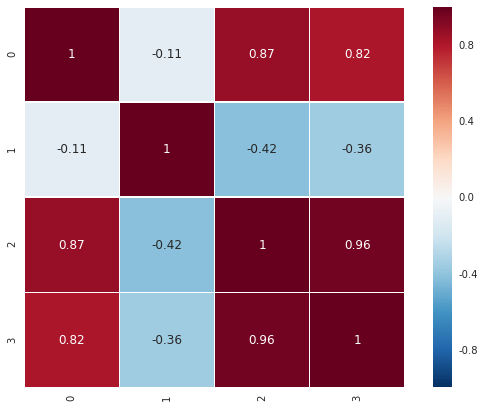

In [138]:
#查看相关图矩阵，找线性关系最强的两个变量做最小二乘估计
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sns.heatmap(np.corrcoef(A.T), square=True, linewidths=.5, annot=True)
plt.show()

C:\Users\Bokkin Wang\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


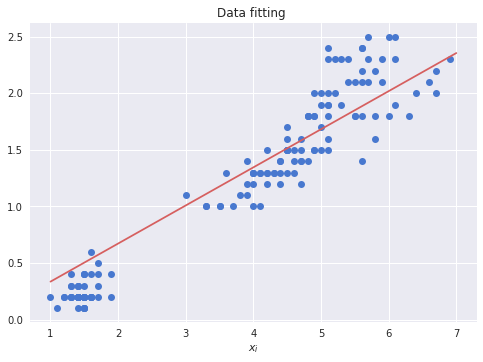

In [153]:
#最小二乘估计系数c
c, resid, rank, sigma = linalg.lstsq(A[:,2][:, np.newaxis],A[:,3][:, np.newaxis])
#拟合的回归曲线
xi=A[:,2]
yi=A[:,3]
xi2 = np.r_[1:7:150j].reshape(150,1)
yi2 = c*xi2
#OLS估计的拟合曲线与真实值散点图
plt.plot(xi,yi,"o",xi2,yi2,'r')
plt.xlabel('$x_i$')
plt.title('Data fitting ')
plt.show()

+ 特征值以及特征向量运算

In [142]:
A = np.array(X[0])
XX = A.T.dot(A)
la,v = linalg.eig(XX)
l1,l2,l3,l4 = la
print ("4个特征值："+str(l1)+str(l2)+str(l3)+str(l4))#eigenvalues
for i in range(4):
    print ("第"+str(i+1)+"个特征向量是"+str(v[:,i]))
print ("每个特征向量的模为："+str(np.sum(abs(v**2),axis=0))) #eigenvectors are unitary
v1 = np.array(v[:,0]).T
print ("矩阵乘以特征向量的值-特征值乘以特征向量的值="+str(linalg.norm(XX.dot(v1)-l1*v1))) #check the computation

4个特征值：(9206.5305960671+0j)(314.10307292077505+0j)(12.036019345715532+0j)(3.53031166641183+0j)
第1个特征向量是[0.75116805 0.37978837 0.51315094 0.16787934]
第2个特征向量是[ 0.28583096  0.54488976 -0.70889874 -0.34475845]
第3个特征向量是[ 0.49942378 -0.67502499 -0.05471983 -0.54029889]
第4个特征向量是[ 0.32345496 -0.32124324 -0.48077482  0.74902286]
每个特征向量的模为：[1. 1. 1. 1.]
矩阵乘以特征向量的值-特征值乘以特征向量的值=3.2155493553843714e-12


+ 奇异值分解

In [155]:
A = np.array(X[0])
M,N = A.shape
U,s,Vh = linalg.svd(A)
Sig = linalg.diagsvd(s,M,N)
U, Vh = U, Vh
U

array([[-6.16171172e-02,  1.29969428e-01, -5.58364155e-05, ...,
        -9.34637342e-02, -9.60224157e-02, -8.09922905e-02],
       [-5.80722977e-02,  1.11371452e-01,  6.84386629e-02, ...,
         3.66755322e-02, -3.24463474e-02,  1.27273399e-02],
       [-5.67633852e-02,  1.18294769e-01,  2.31062793e-03, ...,
         3.08252776e-02,  1.95234663e-01,  1.35567696e-01],
       ...,
       [-9.40702260e-02, -4.98348018e-02, -4.14958083e-02, ...,
         9.81822841e-01, -2.17978813e-02, -8.85972146e-03],
       [-9.48993908e-02, -5.62107520e-02, -2.12386574e-01, ...,
        -2.14264126e-02,  9.42038920e-01, -2.96933496e-02],
       [-8.84882764e-02, -5.16210172e-02, -9.51442925e-02, ...,
        -8.52768485e-03, -3.02139863e-02,  9.73577349e-01]])

In [156]:
Sig

array([[95.95066751,  0.        ,  0.        ,  0.        ],
       [ 0.        , 17.72295328,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  3.46929666,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.87891236],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.

In [157]:
Vh

array([[-0.75116805, -0.37978837, -0.51315094, -0.16787934],
       [ 0.28583096,  0.54488976, -0.70889874, -0.34475845],
       [ 0.49942378, -0.67502499, -0.05471983, -0.54029889],
       [ 0.32345496, -0.32124324, -0.48077482,  0.74902286]])

In [158]:
U.dot(Sig.dot(Vh))

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3